## Credit Scoring Model on GPU

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import pprint as pp
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import DenseFeatures, Dense, Activation, LayerNormalization, Flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from IPython.display import display
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
print('TensorFlow version: ' + tf.__version__)

TensorFlow version: 2.11.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4867476263508553294
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1673999156
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8529602303512699172
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
# credit_data = pd.read_csv('german_credit_data.csv')
# credit_data.to_hdf('credit_data.h5', key='df', mode='w')
credit_data = pd.read_hdf('credit_data.h5', 'df')  
display(credit_data)

,CustomerID,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,713a336c-a255-4e2d-9d57-90b3e99e2f06,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,140b363f-a3fe-4828-a33f-7284dfdb3969,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,43b7b51d-5eda-4860-b461-ebef3d3436f4,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,f40eaf08-e6d1-4765-ab20-c5f7faca1635,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,1728910a-d3ff-4799-ac50-203a3a58a3fb,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,e77fa77b-78da-4607-a2fa-ede36c1e968f,greater_200,27,credits_paid_to_date,furniture,4650,less_100,1_to_4,3,male,...,savings_insurance,40,none,own,1,skilled,1,none,yes,No Risk
4996,6e71db4b-375c-42e1-b4a8-3292c007967a,0_to_200,11,prior_payments_delayed,furniture,250,greater_1000,4_to_7,3,male,...,car_other,32,bank,own,1,unemployed,1,none,yes,No Risk
4997,db501d22-e0c9-4f38-bf05-7f2c1df35395,no_checking,32,outstanding_credit,appliances,6536,unknown,greater_7,5,male,...,unknown,54,stores,own,2,unskilled,2,yes,yes,Risk
4998,802055d6-6aa7-4532-bf1c-0b8b114b483d,0_to_200,38,outstanding_credit,other,1597,500_to_1000,greater_7,3,female,...,savings_insurance,27,stores,own,1,skilled,1,none,yes,Risk


In [6]:
data = credit_data.copy()

In [7]:
# Name of the label column.
label = 'Risk'
id_column = 'CustomerID'
data[label].value_counts().to_frame().T

,No Risk,Risk
Risk,3330,1670


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CustomerID                5000 non-null   object
 1   CheckingStatus            5000 non-null   object
 2   LoanDuration              5000 non-null   int64 
 3   CreditHistory             5000 non-null   object
 4   LoanPurpose               5000 non-null   object
 5   LoanAmount                5000 non-null   int64 
 6   ExistingSavings           5000 non-null   object
 7   EmploymentDuration        5000 non-null   object
 8   InstallmentPercent        5000 non-null   int64 
 9   Sex                       5000 non-null   object
 10  OthersOnLoan              5000 non-null   object
 11  CurrentResidenceDuration  5000 non-null   int64 
 12  OwnsProperty              5000 non-null   object
 13  Age                       5000 non-null   int64 
 14  InstallmentPlans        

In [9]:
# Name of the label column.
label = 'Risk'
id_column = 'CustomerID'
data[label].value_counts().to_frame().T

,No Risk,Risk
Risk,3330,1670


In [10]:
label_new = label + '_target'
data[label_new] = data[label].apply(lambda x: 1 if x == 'Risk' else 0)
data.drop(label, axis=1, inplace=True)

In [11]:
train = 2/3
test = 1 - train
label_lst = [label_new]
train_data, test_data = train_test_split(data, test_size=test, random_state=0, stratify=data[label_lst])
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
train_data[label_new].value_counts().to_frame().T

Train data shape: (3333, 22)
Test data shape: (1667, 22)


,0,1
Risk_target,2220,1113


In [12]:
print("Training dataset")
display(train_data.agg({label_new : ['sum', 'count']}))
print("Test dataset")
display(test_data.agg({label_new : ['sum', 'count']}))

Training dataset


,Risk_target
sum,1113
count,3333


Test dataset


,Risk_target
sum,557
count,1667


In [13]:
def nominal_to_ratio(df, column, target):
    agr = df.groupby(column, as_index=False, dropna=False)[target].aggregate(['sum','count'])
    agr['ratio'] = agr['sum'] / agr['count']
    agr.reset_index(inplace=True)
    agr = agr[[column, 'ratio']]
    return dict(agr.values)

In [14]:
nominalFeatures = ['CheckingStatus','CreditHistory','LoanPurpose','ExistingSavings','EmploymentDuration','Sex',
'OthersOnLoan','OwnsProperty','InstallmentPlans','Housing','Job','Telephone','ForeignWorker']

train_data_ratio = train_data.copy()
test_data_ratio = test_data.copy()

ratioFeatures = []

for name in nominalFeatures:
    ratio_map = nominal_to_ratio(train_data_ratio, name, label_new)
    ratio_name = 'Ratio_' + name
    train_data_ratio[ratio_name] = train_data_ratio[name].map(ratio_map)
    train_data_ratio.drop(name, axis=1, inplace=True)
    
    test_data_ratio[ratio_name] = test_data_ratio[name].map(ratio_map)
    test_data_ratio.drop(name, axis=1, inplace=True)
    ratioFeatures.append(ratio_name)

print(ratioFeatures)
display(train_data_ratio)

['Ratio_CheckingStatus', 'Ratio_CreditHistory', 'Ratio_LoanPurpose', 'Ratio_ExistingSavings', 'Ratio_EmploymentDuration', 'Ratio_Sex', 'Ratio_OthersOnLoan', 'Ratio_OwnsProperty', 'Ratio_InstallmentPlans', 'Ratio_Housing', 'Ratio_Job', 'Ratio_Telephone', 'Ratio_ForeignWorker']


,CustomerID,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,Risk_target,Ratio_CheckingStatus,...,Ratio_ExistingSavings,Ratio_EmploymentDuration,Ratio_Sex,Ratio_OthersOnLoan,Ratio_OwnsProperty,Ratio_InstallmentPlans,Ratio_Housing,Ratio_Job,Ratio_Telephone,Ratio_ForeignWorker
3985,1569bb6b-f83f-45fb-9284-864289d8b5db,20,3822,3,3,35,1,1,1,0.095488,...,0.143533,0.730706,0.356211,0.267500,0.439681,0.174917,0.324096,0.257403,0.533036,0.328427
2467,46420c4e-fe41-4517-a6a6-33b2104b25c8,36,6040,5,4,55,2,2,1,0.569337,...,0.518919,0.730706,0.356211,0.683084,0.705263,0.223373,0.324096,0.257403,0.533036,0.328427
3290,ae2546dd-5ce1-4198-86d2-c971f88f9391,36,6203,4,5,43,2,2,1,0.569337,...,0.625000,0.730706,0.356211,0.683084,0.439681,0.223373,0.324096,0.257403,0.533036,0.328427
2523,78c7bf4e-f4bd-490c-abda-88c0b77e730b,8,1312,1,1,24,1,1,0,0.095488,...,0.143533,0.237374,0.297468,0.267500,0.265471,0.174917,0.118949,0.210811,0.198892,0.328427
1084,bd697901-dbe2-40a1-aa82-89db5c8c1005,8,1638,3,4,38,1,1,0,0.569337,...,0.338501,0.080906,0.356211,0.267500,0.055405,0.386151,0.118949,0.392941,0.533036,0.328427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,3a07fe8e-d341-4112-a09a-827e1073b704,19,4349,3,2,23,2,2,0,0.224771,...,0.483501,0.080906,0.356211,0.267500,0.439681,0.174917,0.324096,0.257403,0.533036,0.328427
2474,77d08099-3a56-4140-996e-cd0a18a41155,12,3223,4,3,35,1,1,0,0.569337,...,0.625000,0.237374,0.356211,0.267500,0.439681,0.386151,0.118949,0.392941,0.198892,0.328427
3191,8a9dc768-9b0c-4f0e-9ac7-72393810f754,33,6712,3,4,43,3,2,1,0.414286,...,0.518919,0.413187,0.297468,0.267500,0.705263,0.386151,0.324096,0.347636,0.533036,0.328427
3664,d83f91fe-d8fb-43d6-affe-c2a00e0836e5,33,4539,4,5,51,2,2,1,0.569337,...,0.518919,0.730706,0.356211,0.683084,0.265471,0.223373,0.324096,0.257403,0.533036,0.328427


In [15]:
label = label_new
id_column = 'CustomerID'

### Define continuous list
numericFeatures  = ['LoanDuration','LoanAmount','InstallmentPercent','CurrentResidenceDuration','Age','ExistingCreditsCount','Dependents']  
numericFeatures = numericFeatures + ratioFeatures
### Define the categorical list
objectFeatures = []

# Target column name.
TARGET_COLUMN_NAME = label
# Numeric feature names.
NUMERIC_FEATURE_NAMES = numericFeatures
# Categorical features and their vocabulary lists.
CATEGORICAL_FEATURE_NAMES = objectFeatures

print(TARGET_COLUMN_NAME)
print(NUMERIC_FEATURE_NAMES)
print(CATEGORICAL_FEATURE_NAMES)

Risk_target
['LoanDuration', 'LoanAmount', 'InstallmentPercent', 'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount', 'Dependents', 'Ratio_CheckingStatus', 'Ratio_CreditHistory', 'Ratio_LoanPurpose', 'Ratio_ExistingSavings', 'Ratio_EmploymentDuration', 'Ratio_Sex', 'Ratio_OthersOnLoan', 'Ratio_OwnsProperty', 'Ratio_InstallmentPlans', 'Ratio_Housing', 'Ratio_Job', 'Ratio_Telephone', 'Ratio_ForeignWorker']
[]


In [16]:
def specify_feature_usages(df, label):
    feature_usages = list()
    feature_names = list()

    for feature_name in NUMERIC_FEATURE_NAMES:
        
        mean = df[feature_name].mean()
        std = df[feature_name].std()
        
        def zscore(x):
            x = tf.dtypes.cast(x, tf.float32)
            return (x - mean)/std
        
        feature_usage = tf.feature_column.numeric_column(key=feature_name, normalizer_fn=zscore)
        feature_usages.append(feature_usage)
        feature_names.append(feature_name)

    for feature_name in CATEGORICAL_FEATURE_NAMES:
        
        aggregate = df.groupby(feature_name)[label].agg(['sum','count'])
        aggregate['share'] = aggregate['sum'] / aggregate['count']
        aggregate.sort_values('share', ascending=False, inplace=True)
        vocabulary = aggregate.index.values.tolist()
        
        feature_usage = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
            key=feature_name, vocabulary_list=vocabulary, default_value=0
        ))
        feature_usages.append(feature_usage)
        feature_names.append(feature_name)

    return feature_usages, feature_names

In [17]:
train_data = train_data_ratio.copy()
test_data = test_data_ratio.copy()

feature_columns, feature_names = specify_feature_usages(train_data, label)
l_inputs = len(feature_columns)
l_outputs = len([label])
print('inputs={inputs}, output={output}'.format(inputs=l_inputs,output=l_outputs))
pp.pprint(feature_columns)

inputs=20, output=1
[NumericColumn(key='LoanDuration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_feature_usages.<locals>.zscore at 0x7f8ba008bb80>),
 NumericColumn(key='LoanAmount', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_feature_usages.<locals>.zscore at 0x7f8ba008bee0>),
 NumericColumn(key='InstallmentPercent', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_feature_usages.<locals>.zscore at 0x7f8ba008b310>),
 NumericColumn(key='CurrentResidenceDuration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_feature_usages.<locals>.zscore at 0x7f8ba008b280>),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_feature_usages.<locals>.zscore at 0x7f8b38def0d0>),
 NumericColumn(key='ExistingCreditsCount', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function specify_fea

In [18]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_cols, shuffle=True):
    dataframe = dataframe.copy()
    total_rows = dataframe.shape[0]
    batch_size = int(total_rows/10)
    labels = dataframe[target_cols]
    features = dataframe.drop(target_cols, axis=1)
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features))
        ds = ds.batch(batch_size)
    return ds

In [19]:
# Convert the dataset into a TensorFlow dataset.
train_dataset = df_to_dataset(train_data, label, True)
test_dataset = df_to_dataset(test_data, label, True)

In [20]:
model = Sequential()
model.add(DenseFeatures(feature_columns))
model.add(LayerNormalization(axis=1))
model.add(Dense(l_inputs, activation=tf.nn.sigmoid))
model.add(Dense(int(l_inputs/2)+1, activation=tf.nn.sigmoid))
model.add(Dense(l_outputs, activation=tf.nn.softmax))

METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=METRICS)

In [21]:
model.fit(train_dataset, verbose=0)

In [22]:
# evaluate the model
print("Training dataset")
scores = model.evaluate(train_dataset, verbose=0)
scores_metrics = zip(model.metrics_names, scores)
for m, s in list(scores_metrics):
    print(m, s)
    
print("Test dataset")
scores = model.evaluate(test_dataset, verbose=0)
scores_metrics = zip(model.metrics_names, scores)
for m, s in list(scores_metrics):
    print(m, s)

Training dataset
loss 10.157008171081543
accuracy 0.33393338322639465
precision 0.33393338322639465
recall 1.0
auc 0.5
Test dataset
loss 10.153963088989258
accuracy 0.33413317799568176
precision 0.33413317799568176
recall 1.0
auc 0.5


In [23]:
y_predicted = model.predict(test_dataset)

11/11 [==============================] - 0s 6ms/step


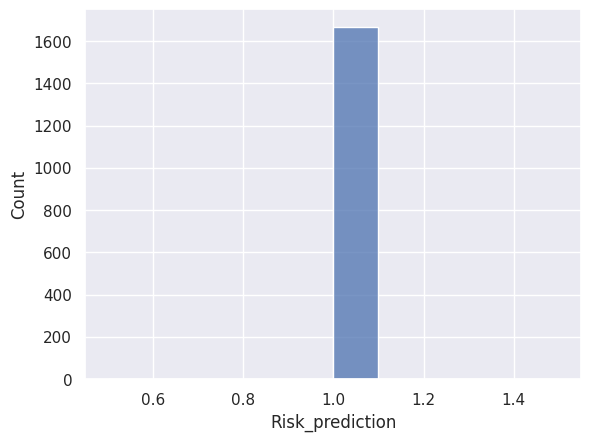

In [24]:
df_hist = pd.DataFrame(y_predicted)
df_hist.columns = ["Risk_prediction"]
sns.histplot(data=df_hist, x="Risk_prediction", bins=10)
plt.show()

In [25]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_actual = test_data[label]
matrix = confusion_matrix(y_actual, y_predicted, labels=[1,0])
report = classification_report(y_actual, y_predicted)
print(matrix)
print(report)

[[ 557    0]
 [1110    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1110
           1       0.33      1.00      0.50       557

    accuracy                           0.33      1667
   macro avg       0.17      0.50      0.25      1667
weighted avg       0.11      0.33      0.17      1667



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
